No GPU available, using the CPU instead.


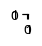

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

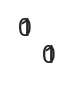

In [2]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [3]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

# init

## reloading datasets

In [4]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [5]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [6]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [7]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

3480


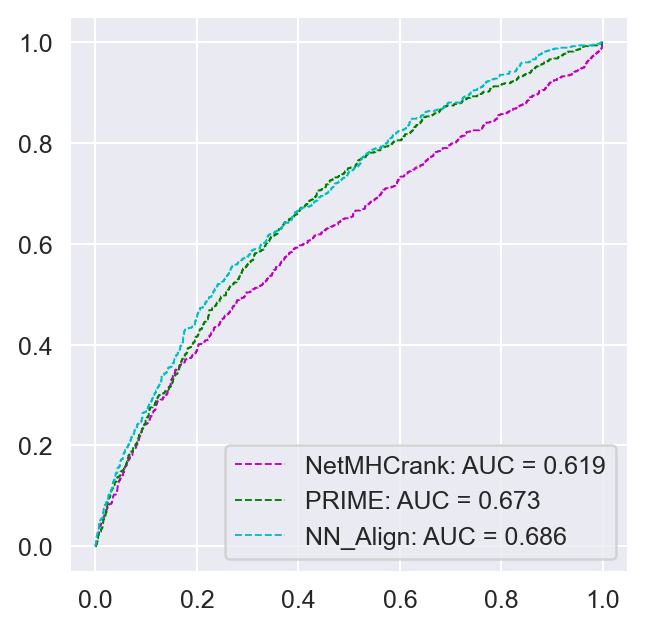

In [9]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

In [10]:
from src.baselines import plot_related_baseline_roc

In [11]:
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

(86, 94)

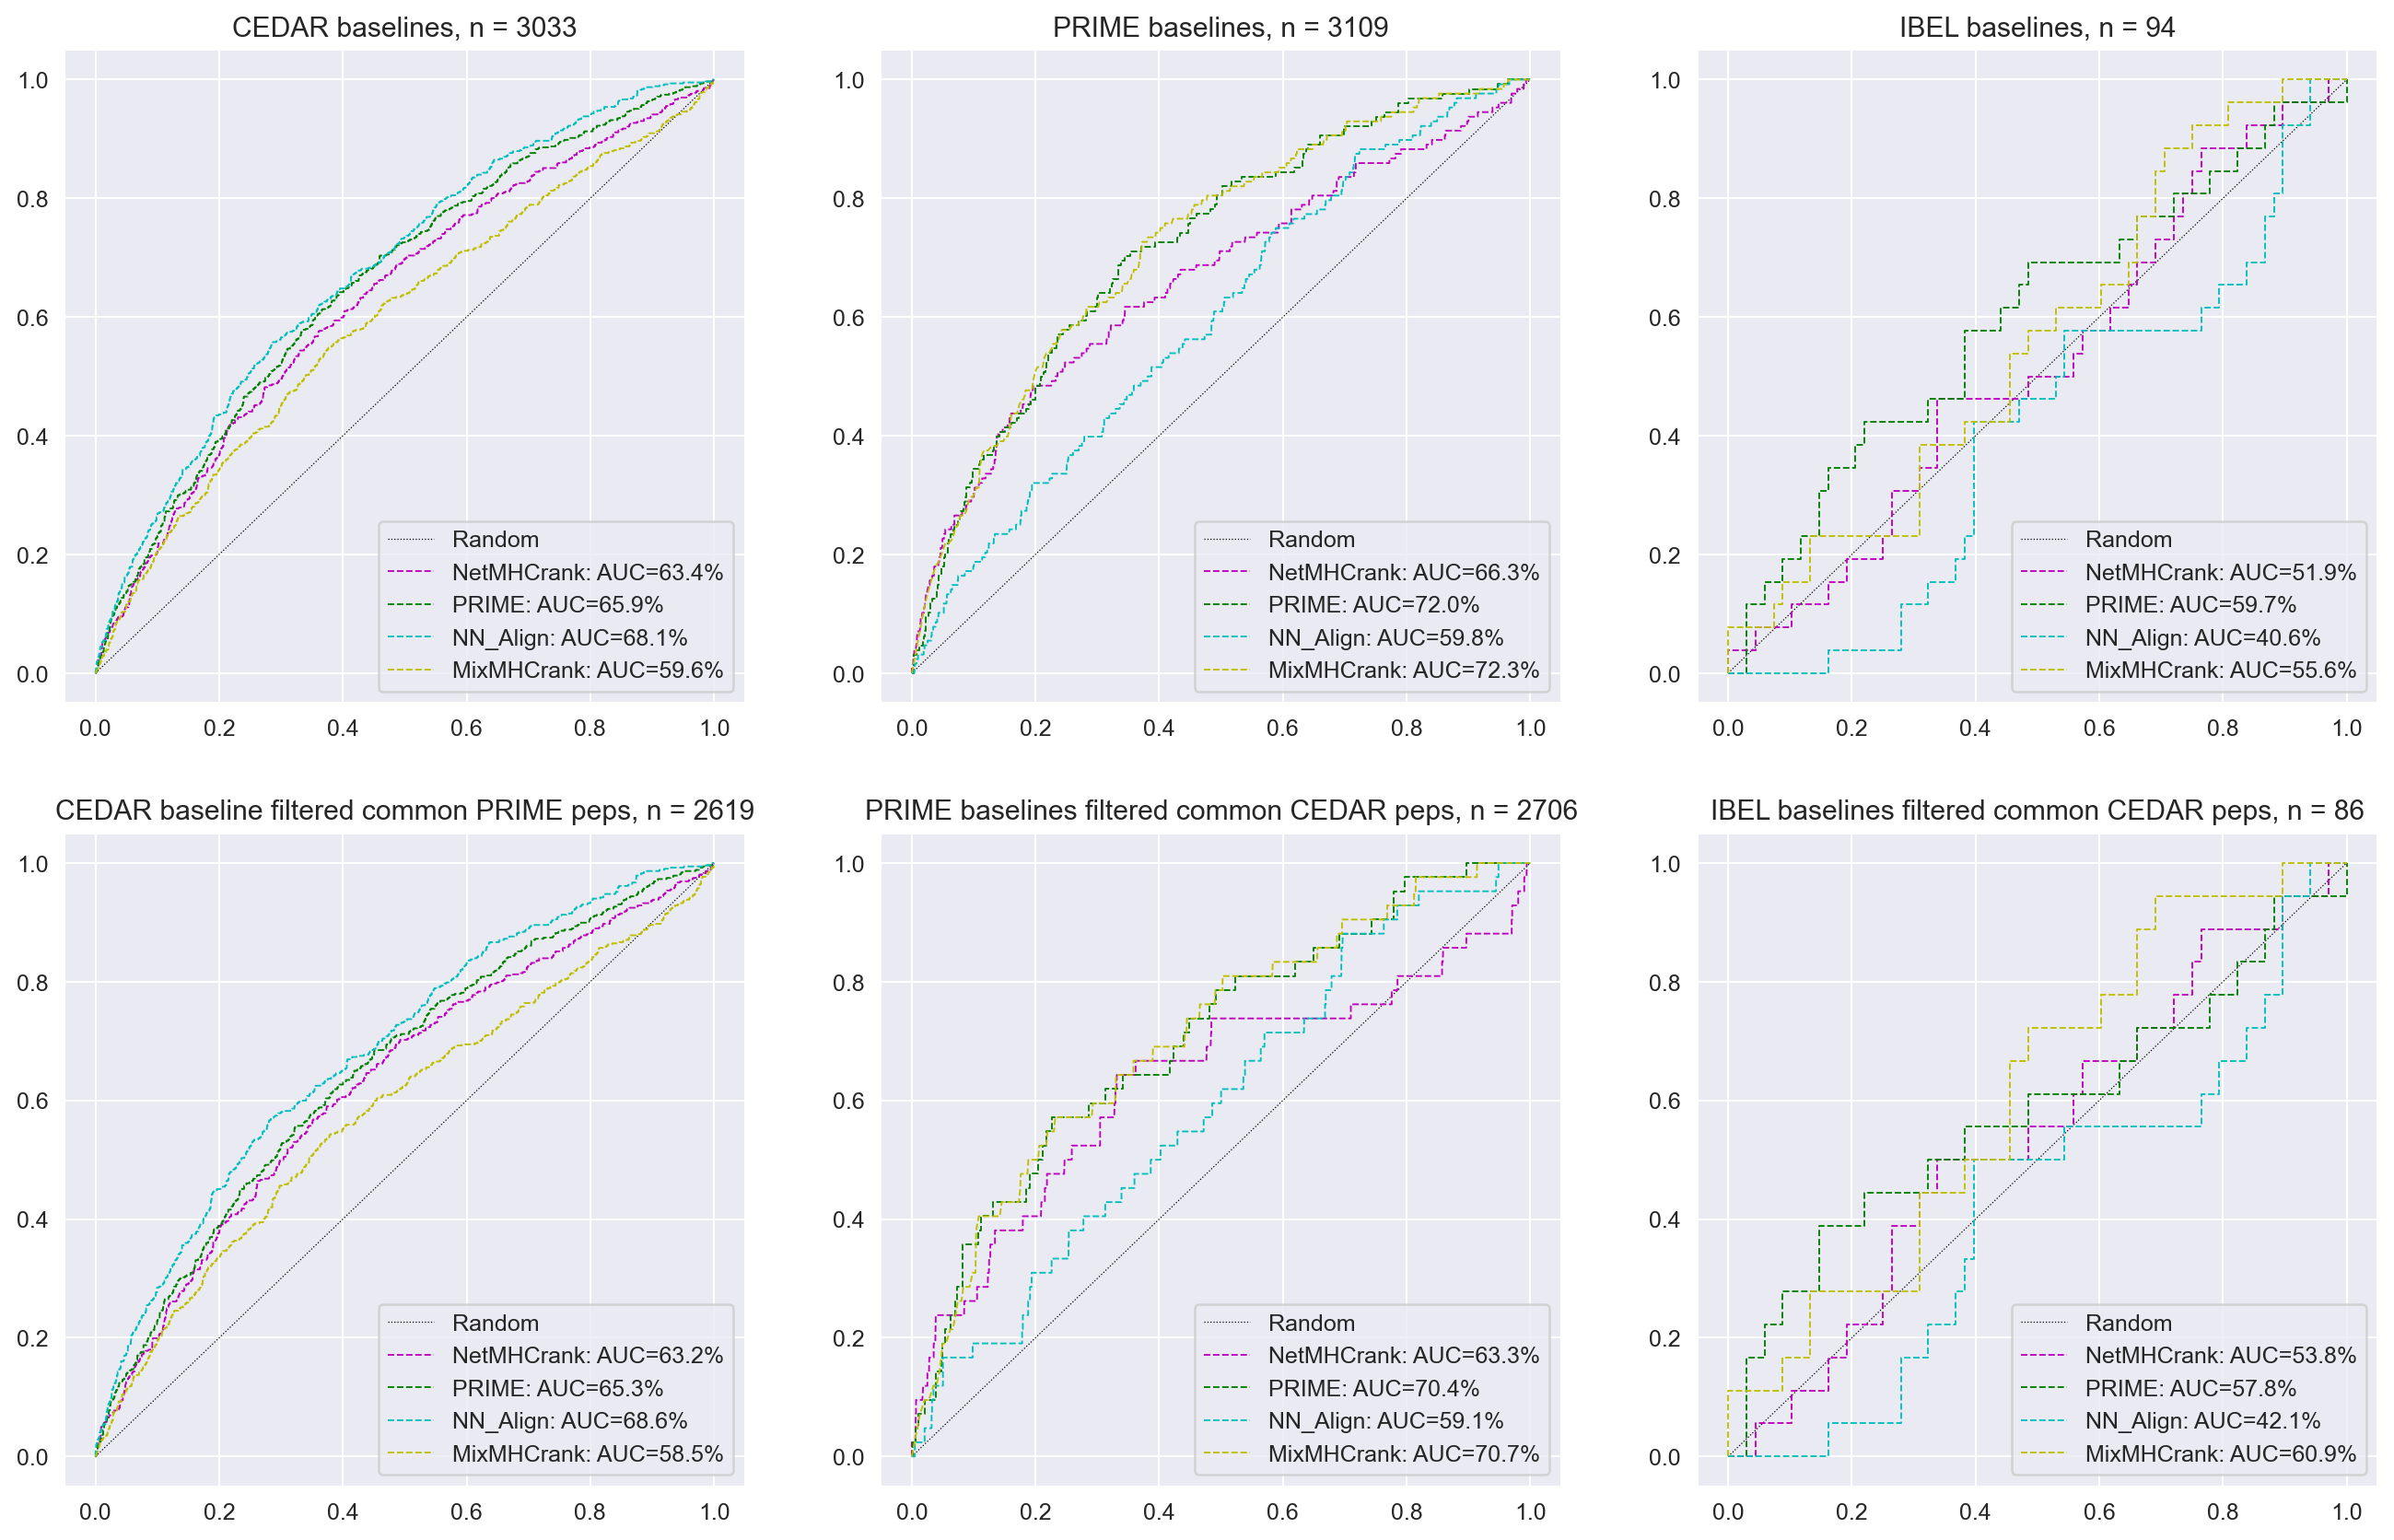

In [12]:
f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

In [13]:
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

0.5784313725490196

In [14]:
cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']

# Re-set threshold

In [16]:
from src.metrics import get_metrics
from sklearn.metrics import matthews_corrcoef

In [21]:
np.linspace(0.05, .95, 25)

array([0.05  , 0.0875, 0.125 , 0.1625, 0.2   , 0.2375, 0.275 , 0.3125,
       0.35  , 0.3875, 0.425 , 0.4625, 0.5   , 0.5375, 0.575 , 0.6125,
       0.65  , 0.6875, 0.725 , 0.7625, 0.8   , 0.8375, 0.875 , 0.9125,
       0.95  ])

In [65]:
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    for t in thresholds:
        preds = scores > t
        results[t] = matthews_corrcoef(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    print(f'\tBest : Threshold= {best[0]:.3f}, MCC= {best[1]:.3f}')
    return best[0], best[1]

# Example
preds_df = pd.read_csv('../output/221122_mutscore_cedar_fixed/raw/cedar_preds_onehot_None_icore_mut_EL_rank_mut_aa_props.csv')

t_list = []
mcc_list = []
for f in preds_df.fold.unique():
    print(f'\nCurrent fold : {f}')
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 25, 'pred', 'agg_label')
    t_list.append(t)
    mcc_list.append(mcc)
    
np.mean(mcc_list), np.mean(t_list)


Current fold : 0
	Best : Threshold= 0.350, MCC= 0.333

Current fold : 1
	Best : Threshold= 0.275, MCC= 0.298

Current fold : 2
	Best : Threshold= 0.162, MCC= 0.154

Current fold : 3
	Best : Threshold= 0.200, MCC= 0.323

Current fold : 4
	Best : Threshold= 0.275, MCC= 0.453

Current fold : 5
	Best : Threshold= 0.200, MCC= 0.382

Current fold : 6
	Best : Threshold= 0.387, MCC= 0.366

Current fold : 7
	Best : Threshold= 0.237, MCC= 0.325

Current fold : 8
	Best : Threshold= 0.312, MCC= 0.286

Current fold : 9
	Best : Threshold= 0.312, MCC= 0.277


(0.31972651124419793, 0.27125000000000005)

In [74]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.ensemble import RandomForestClassifier

cedar_trainset = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_evalset = pd.read_csv('../data/mutant/221117_prime_related_newcore_fold.csv')
ibel_evalset = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')

_, aa_cols = get_aa_properties(cedar_trainset.sample(1))
# Shannon for first 3
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['dissimilarity_score', 'blsm_mut_score'])

for k, ics_dict, best_kwargs in zip(['Compromise'],
                                   [ics_kl],
                                   [best_agg]):
    
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)
    
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_trainset, model, ics_dict, best_kwargs, n_jobs=8)
    kcv_preds, _ = evaluate_trained_models_sklearn(cedar_trainset, trained_models, ics_dict, train_dataframe=cedar_trainset,
                                                encoding_kwargs = best_kwargs, concatenated = False, n_jobs=8)
    break

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [114]:
def threshold_pred(df, thresholds, predcol, targetcol):
    df = df.copy()
    df['predicted_label'] = np.nan
    for k in df.fold.unique():
        tmp = df.query('fold==@k')
        preds = (tmp[predcol]>=thresholds[k]).astype(int)
        df.loc[tmp.index, 'predicted_label'] = preds
    return df

thresholds = {}
for f in sorted(preds_df.fold.unique()):
    print(f'\nCurrent fold : {f}')
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 50, 'pred', 'agg_label')
    thresholds[f] = t
thresholded_df = threshold_pred(preds_df, thresholds, 'pred', 'agg_label')


Current fold : 0
	Best : Threshold= 0.344, MCC= 0.333

Current fold : 1
	Best : Threshold= 0.289, MCC= 0.312

Current fold : 2
	Best : Threshold= 0.160, MCC= 0.172

Current fold : 3
	Best : Threshold= 0.215, MCC= 0.318

Current fold : 4
	Best : Threshold= 0.270, MCC= 0.446

Current fold : 5
	Best : Threshold= 0.215, MCC= 0.388

Current fold : 6
	Best : Threshold= 0.381, MCC= 0.366

Current fold : 7
	Best : Threshold= 0.252, MCC= 0.312

Current fold : 8
	Best : Threshold= 0.289, MCC= 0.308

Current fold : 9
	Best : Threshold= 0.307, MCC= 0.277


In [115]:
from sklearn.metrics import precision_score, f1_score, recall_score
print('per fold thresholding\n', 
      f"F1:\t{round(f1_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
       f"\nPrec:\t{round(precision_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
       f"\nRecall:\t{round(recall_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
      f"\nMCC:\t{round(matthews_corrcoef(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}")
print('\nmean_thresholding\n', 
      f"F1:\t{round(f1_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
       f"\nPrec:\t{round(precision_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
       f"\nRecall:\t{round(recall_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
      f"\nMCC:\t{round(matthews_corrcoef(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}")

per fold thresholding
 F1:	0.4557 
Prec:	0.3974 
Recall:	0.5341 
MCC:	0.2906

mean_thresholding
 F1:	0.423 
Prec:	0.4153 
Recall:	0.4311 
MCC:	0.2679


# Check AUC per fold (with concat)

In [119]:
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    for t in thresholds:
        preds = scores > t
        results[t] = matthews_corrcoef(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    print(f'\tBest : Threshold= {best[0]:.3f}, MCC= {best[1]:.3f}')
    threshold, mccoef = best[0], best[1]
    return threshold, mccoef

In [155]:
compromise = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score.csv')

t_list = []
mcc_list = []
new_preds = preds_df.copy()
for f in preds_df.fold.unique():
    print(f'\nCurrent fold : {f}')
    print(preds_df.query('fold==@f').pred.median())
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 25, 'pred', 'agg_label')
    t_list.append(t)
    mcc_list.append(mcc)
    idx = new_preds.query('fold==@f').index
    new_preds.loc[idx, 'pred']=new_preds.loc[idx,'pred']-t
np.mean(mcc_list), np.mean(t_list)


Current fold : 0
0.15993175551018354
	Best : Threshold= 0.350, MCC= 0.333

Current fold : 1
0.17832241010386815
	Best : Threshold= 0.275, MCC= 0.298

Current fold : 2
0.1792017697364559
	Best : Threshold= 0.162, MCC= 0.154

Current fold : 3
0.2123155649593636
	Best : Threshold= 0.200, MCC= 0.323

Current fold : 4
0.16671873172727658
	Best : Threshold= 0.275, MCC= 0.453

Current fold : 5
0.1667924593801879
	Best : Threshold= 0.200, MCC= 0.382

Current fold : 6
0.1954020272792044
	Best : Threshold= 0.387, MCC= 0.366

Current fold : 7
0.1675074171683959
	Best : Threshold= 0.237, MCC= 0.325

Current fold : 8
0.1562837196668856
	Best : Threshold= 0.312, MCC= 0.286

Current fold : 9
0.1710313120842981
	Best : Threshold= 0.312, MCC= 0.277


(0.31972651124419793, 0.27125000000000005)

In [159]:
roc_auc_score(new_preds['agg_label'], new_preds['pred']), roc_auc_score(preds_df['agg_label'], preds_df['pred'])

(0.6800962219808901, 0.7188845534162631)

fold
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
7    AxesSubplot(0.125,0.11;0.775x0.77)
8    AxesSubplot(0.125,0.11;0.775x0.77)
9    AxesSubplot(0.125,0.11;0.775x0.77)
Name: mean_pred, dtype: object

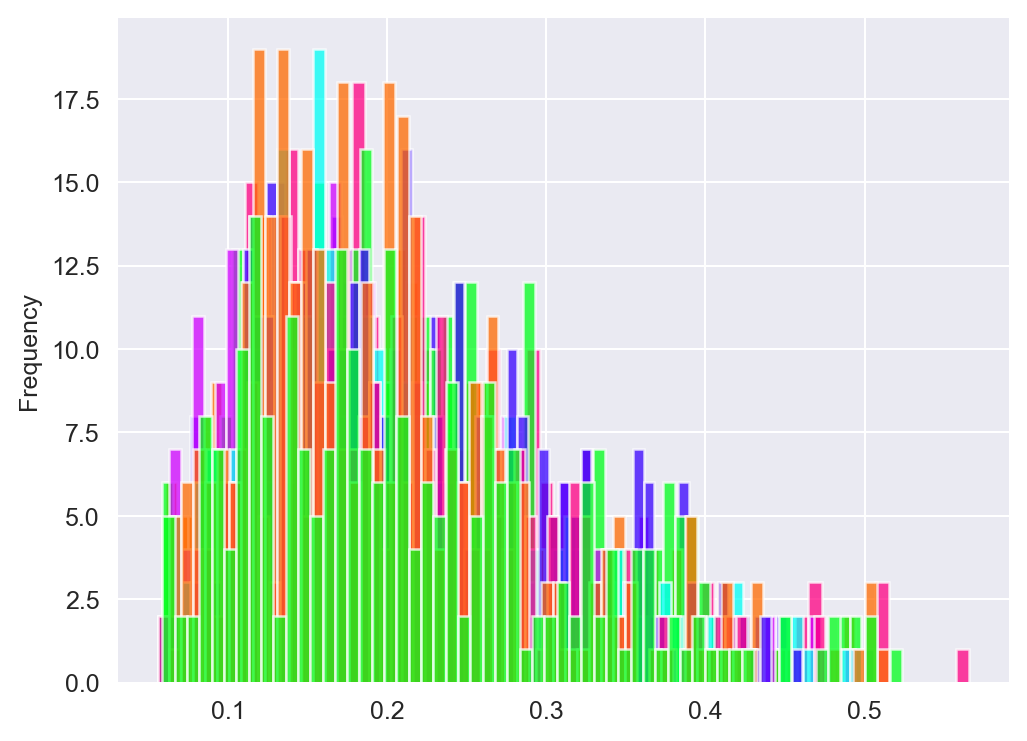

In [126]:
f,a = plt.subplots(len(compromise.fold.unique()), 1, figsize=(10, 5*len(compromise.fold.unique())))
compromise.groupby(['fold'])['mean_pred'].plot(kind='hist', alpha=0.75, bins=60)

In [129]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier

best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score'])

best_models_retrained = {}

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)

trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model, None, best_agg, n_jobs=8)
    

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

In [150]:
metrics, preds = evaluate_trained_models_sklearn(prime_aligned, trained_models, None, train_dataframe=cedar_aligned, concatenated=True, encoding_kwargs=best_agg)

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [151]:
for k in metrics:
    print(k, round(metrics[k]['auc'],3), round(metrics[k]['auc_01'],3))

0 0.706 0.569
1 0.675 0.553
2 0.663 0.549
3 0.685 0.545
4 0.714 0.583
5 0.676 0.57
6 0.706 0.586
7 0.694 0.561
8 0.679 0.586
9 0.679 0.561
concatenated 0.687 0.566


In [152]:
mean_xd = preds.groupby(['Peptide','agg_label','HLA'])[['pred']].mean().reset_index()
roc_auc_score(mean_xd['agg_label'], mean_xd['pred'])

0.677538852192919